# **Predicting Stock Prices with Deep Neural Networks**

This project walks you through the end-to-end data science lifecycle of developing a predictive model for stock price movements with Alpha Vantage APIs and a powerful machine learning algorithm called Long Short-Term Memory (LSTM). By completing this project, you will learn the key concepts of machine learning / deep learning and build a fully functional predictive model for the stock market, all in a single Python file.

In [1]:
#!pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies

In [91]:
config = {
    "alpha_vantage": {
        "key": "QDVUL9L3I646J5IR", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "AAPL",
        "outputsize": "full",
        "key_close": "4. close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

## Data preparation: acquiring financial market data from Alpha Vantage

In [92]:
from datetime import datetime

def download_data(config, start_date, end_date, plot=False):
    # Obtener los datos
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize='full')
    
    # Filtrar datos
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d")
    
    filtered_data = {date: data[date] for date in data if start_datetime <= datetime.strptime(date, "%Y-%m-%d") <= end_datetime}
    data_date = list(filtered_data.keys())
    data_date.sort()
    
    data_close_price = [float(filtered_data[date][config["alpha_vantage"]["key_close"]]) for date in data_date]
    num_data_points = len(data_date)
    display_date_range = f"from {data_date[0]} to {data_date[-1]}"
    
    if plot:
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        plt.xticks([data_date[i] for i in range(0, num_data_points, config["plots"]["xticks_interval"])], rotation=45)
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(True, which='major', axis='y', linestyle='--')
        plt.show()

    return filtered_data, data_date, data_close_price, num_data_points, display_date_range


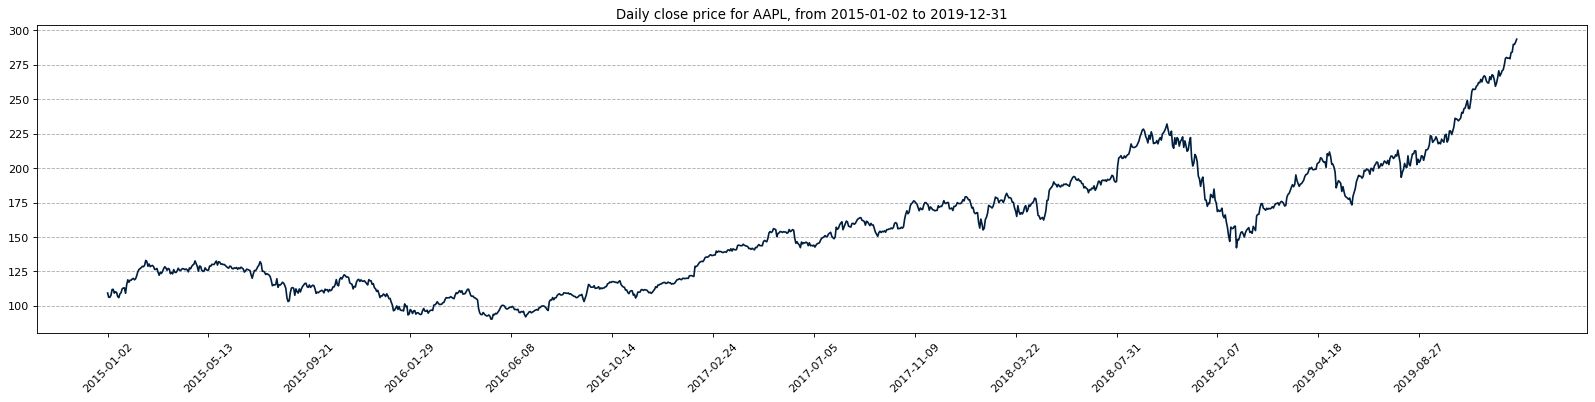

In [93]:
filtered_data, data_date, data_close_price, num_data_points, display_date_range = download_data(config, '2015-01-01', '2019-12-31', plot = config["plots"]["show_plots"])

## Data preparation: normalizing raw financial data

In [94]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        x_array = np.array(x)
        self.mu = np.mean(x_array, axis=(0), keepdims=True)
        self.sd = np.std(x_array, axis=(0), keepdims=True)
        normalized_x = (x_array - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

## Data preparation: generating training and validation datasets

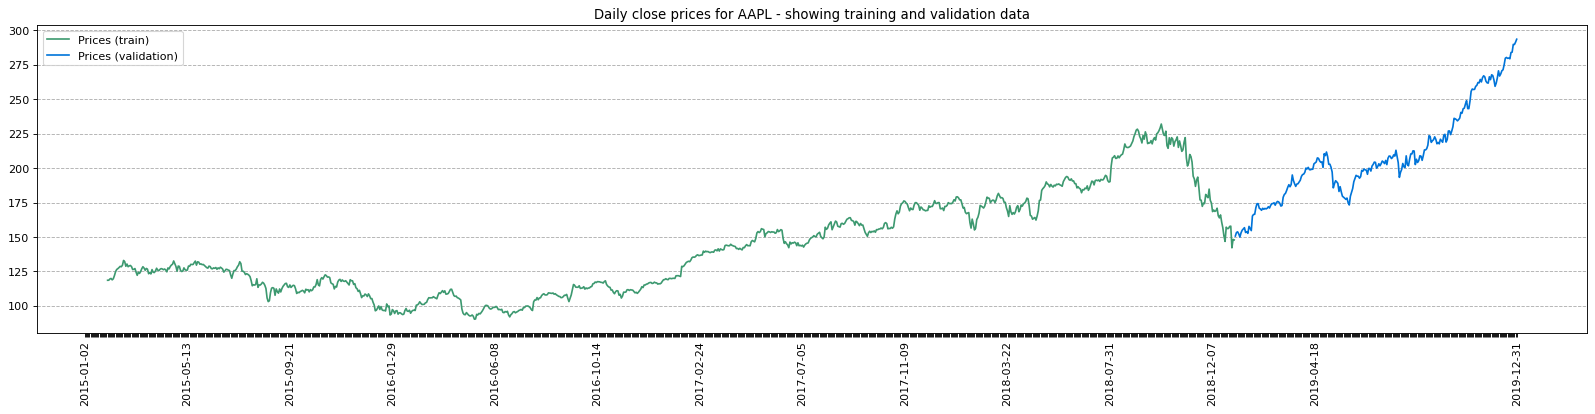

In [95]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset
    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
        plt.grid(True, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

In [96]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (990, 20, 1) (990,)
Validation data shape (248, 20, 1) (248,)


## Defining the LSTM model

In [97]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

## Model training

In [98]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [99]:
# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.030108, test:0.012057 | lr:0.010000
Epoch[2/100] | loss train:0.004891, test:0.008315 | lr:0.010000
Epoch[3/100] | loss train:0.004257, test:0.006317 | lr:0.010000
Epoch[4/100] | loss train:0.002962, test:0.007048 | lr:0.010000
Epoch[5/100] | loss train:0.003109, test:0.005306 | lr:0.010000
Epoch[6/100] | loss train:0.002477, test:0.008077 | lr:0.010000
Epoch[7/100] | loss train:0.002440, test:0.003612 | lr:0.010000
Epoch[8/100] | loss train:0.002979, test:0.006258 | lr:0.010000
Epoch[9/100] | loss train:0.003285, test:0.005214 | lr:0.010000
Epoch[10/100] | loss train:0.002399, test:0.002837 | lr:0.010000
Epoch[11/100] | loss train:0.002874, test:0.004411 | lr:0.010000
Epoch[12/100] | loss train:0.002583, test:0.003720 | lr:0.010000
Epoch[13/100] | loss train:0.002505, test:0.003950 | lr:0.010000
Epoch[14/100] | loss train:0.001913, test:0.004634 | lr:0.010000
Epoch[15/100] | loss train:0.001714, test:0.007264 | lr:0.010000
Epoch[16/100] | loss train:0.00217

## Model evaluation

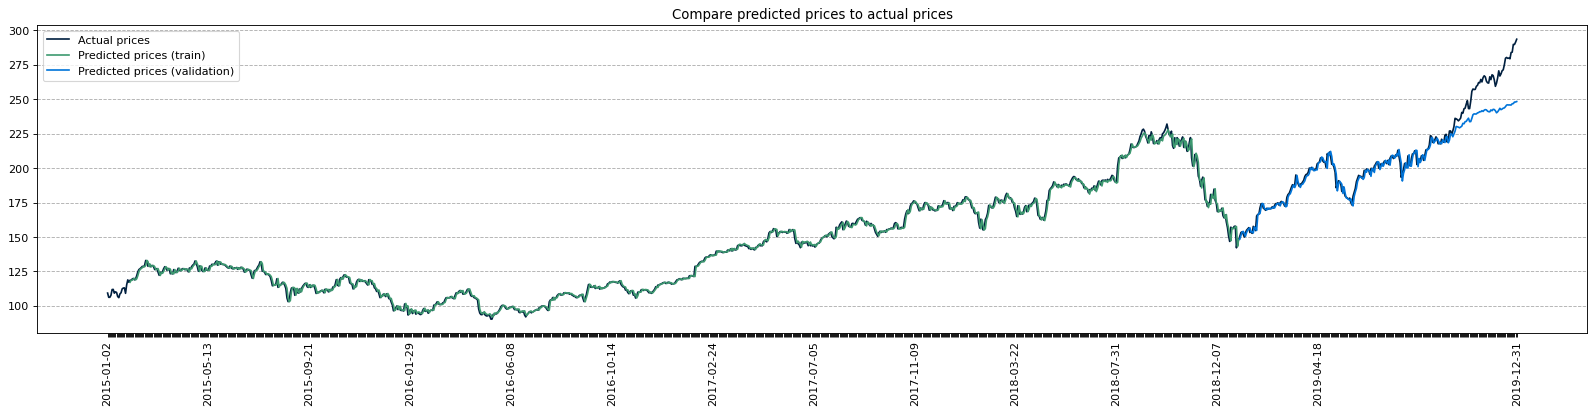

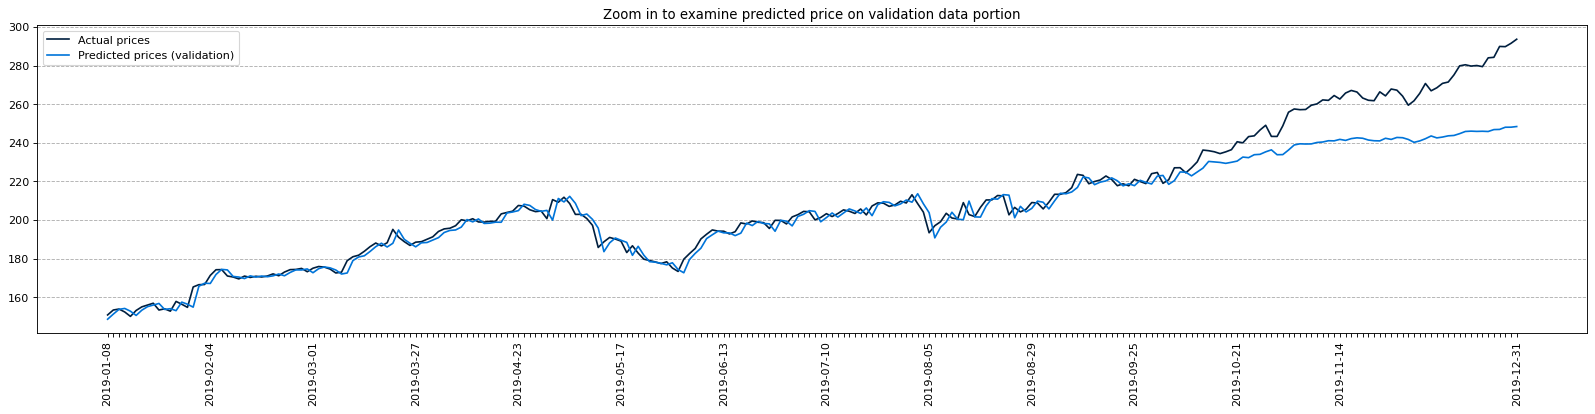

In [11]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does
predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices
    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation
    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

## Predicting future stock prices

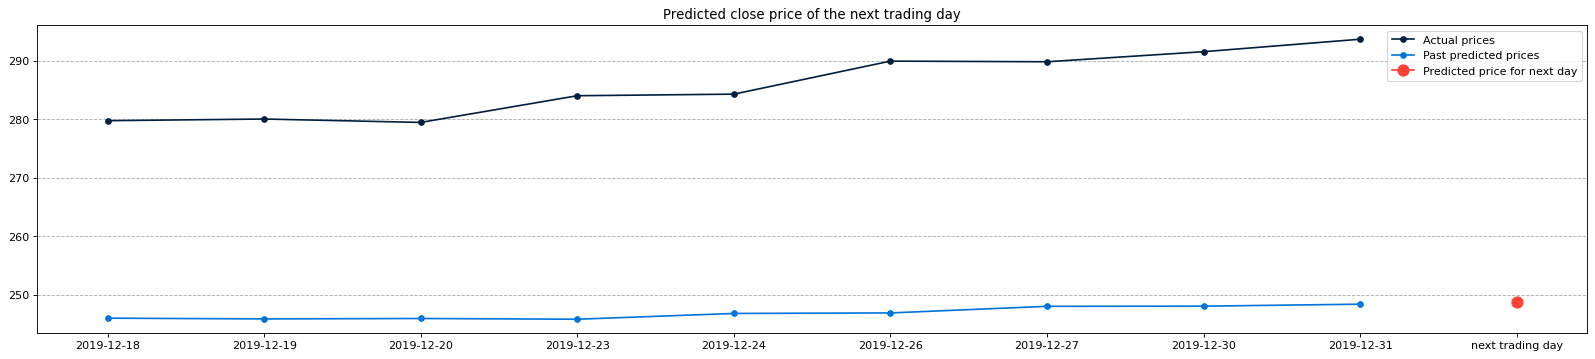

Predicted close price of the next trading day: 248.81


In [12]:
# predict on the unseen data, tomorrow's price 
model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots
    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot
    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()
    
    print("Predicted close price of the next trading day:", round(prediction, 2))

In [13]:
#import requests

#url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey=QDVUL9L3I646J5IR'
#r = requests.get(url)
#data = r.json()

#print(data)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as stat

In [17]:
cpy = pd.read_csv('data/Company.csv')
cpy_tweet = pd.read_csv('data/Company_Tweet.csv')
tweet = pd.read_csv('data/Tweet.csv')

In [18]:
tweets = pd.merge(tweet,cpy_tweet,on='tweet_id',how='inner')
tweets['post_date'] = pd.to_datetime(tweets['post_date'], unit='s')
tweets['date'] = pd.to_datetime(tweets['post_date'].apply(lambda date: date.date()))
aapl = tweets[tweets['ticker_symbol'] == 'AAPL']

In [19]:
!pip install afinn

  Using cached afinn-0.1-py3-none-any.whl


In [20]:
from afinn import Afinn
afinn = Afinn()

In [21]:
aapl['score'] =  aapl['body'].apply(lambda tweet: afinn.score(tweet))

/var/folders/_l/ynx4pv1119nfknfzrs_tsthr0000gn/T/ipykernel_18663/3031911556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl['score'] =  aapl['body'].apply(lambda tweet: afinn.score(tweet))


In [22]:
aapl.to_csv('aapl_sentiment.csv',index=False)

In [23]:
aapl = pd.read_csv('aapl_sentiment.csv')
aapl['date1'] = pd.to_datetime(aapl['date'])
aapl = aapl.sort_values(by='date1')
aapl.index = pd.to_datetime(aapl['date'])

In [56]:
df_AAPL = pd.DataFrame.from_dict(filtered_data, orient='index')
df_AAPL.index = pd.to_datetime(df_AAPL.index)
df_AAPL['date1']=df_AAPL.index
df_AAPL = df_AAPL.sort_values(by='date1')
df_AAPL['4. close'] = df_AAPL.iloc[:, 3].astype(float)
df_AAPL['5. volume'] = df_AAPL.iloc[:, 4].astype(float)

In [26]:
def sentiment_overtime(aapl,df_AAPL,title):
    visual= aapl.groupby('date1')['score'].mean().shift(-1).rolling(30).mean().dropna()
    corr_test = aapl.groupby('date1')['score'].mean().shift(-1).dropna()
    corr, pval = stat.spearmanr(corr_test.reindex(df_AAPL.index), df_AAPL.iloc[:, 3],nan_policy='omit')

    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax2 = ax1.twinx()  # Eje y derecho para el precio de las acciones
    
    ax1.plot(visual.index, visual, label='Tweets Sentiment', color='blue')
    ax2.plot(df_AAPL.index, df_AAPL.iloc[:, 3], color='orange', label='Share Price')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Tweets Sentiment Score', color='blue')
    ax2.set_ylabel('Share Price ($)', color='orange')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax1.set_title("Effects of " + title + " tweets to share price" +
                  "\n Spearman correlation: corr={0:.5f} pval={1:.5f}".format(corr, pval))

    plt.show()

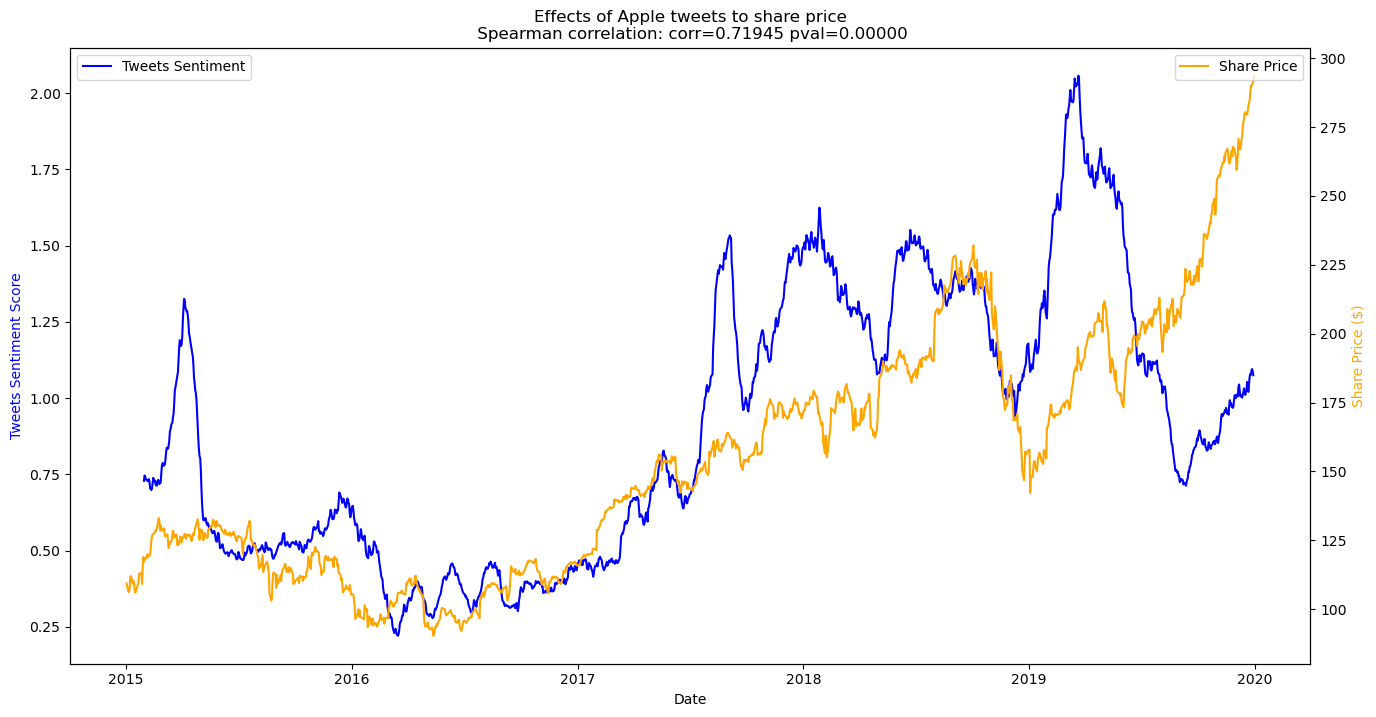

In [27]:
sentiment_overtime(aapl=aapl, df_AAPL=df_AAPL, title='Apple')

## FINBERT

In [28]:
#!pip install transformers

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/opt/homebrew/Caskroom/miniconda/base/envs/stockprice/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [30]:
aapl

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,date,score,date1
date,,,,,,,,,,,
2015-01-01,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01,2.0,2015-01-01
2015-01-01,550731345614602240,TalkMarkets,2015-01-01 19:12:39,Gappy New Year! $SPY $DIA $IWM $INTC $MSFT $AA...,0,0,1,AAPL,2015-01-01,0.0,2015-01-01
2015-01-01,550730566656876548,johnmknox,2015-01-01 19:09:33,Availability & price are a huge problem plagui...,0,0,1,AAPL,2015-01-01,-6.0,2015-01-01
2015-01-01,550730561791066112,Cl4wTr4d3R,2015-01-01 19:09:32,http://profit.ly/1Mq34g Verified $138.47 profi...,0,0,1,AAPL,2015-01-01,4.0,2015-01-01
2015-01-01,550730527301312513,Cl4wTr4d3R,2015-01-01 19:09:24,http://profit.ly/1Mq34f Verified $58.95 profit...,0,0,0,AAPL,2015-01-01,4.0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,1212019899020611586,HottestStockNow,2019-12-31 14:37:16,"Thinking about buying stock in $AAPL, $BBY, $C...",0,0,0,AAPL,2019-12-31,0.0,2019-12-31
2019-12-31,1212020035910275072,RyanSTTrader,2019-12-31 14:37:49,$AAPL Unreal,0,0,1,AAPL,2019-12-31,0.0,2019-12-31
2019-12-31,1212020218878296066,seattlehikertoo,2019-12-31 14:38:33,$AAPL march to more nath. 5G coming and everyo...,0,0,0,AAPL,2019-12-31,0.0,2019-12-31


In [31]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def is_empty_string(str):
    if str == '' or (isinstance(str, float) and math.isnan(str)):
        return True
    else:
        return False


def perform_sentiment_analysis(df):
    results_df = pd.DataFrame([], columns=['date', 'positive', 'negative', 'neutral', 'body'])

    for index, row in df.iterrows():
        date = row["date"]
        tweet_id = row["tweet_id"]
        body = row["body"]

        if is_empty_string(tweet_id) or is_empty_string(body):
            continue

        # Run sentiment analysis
        inputs = tokenizer(body, padding=True, truncation=True, return_tensors='pt')
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

        positive = predictions[:, 0].tolist()
        negative = predictions[:, 1].tolist()
        neutral = predictions[:, 2].tolist()

        new_row = pd.DataFrame({
            "body": [body],
            "positive": [positive],
            "negative": [negative],
            "neutral": [neutral],
            "date": [date]
        })

        results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df

In [ ]:
# Perform sentiment analysis
results_df = perform_sentiment_analysis(aapl)

In [ ]:
#  Group by date
grouped_df = results_df.set_index('date').groupby(pd.Grouper(freq='D')).sum()

In [ ]:
#  Merge with news df
merged_df = pd.merge(daily_df, grouped_df, how="outer", on="date")
merged_df = merged_df.dropna()

#  Plot graphs
#plot_graphs(symbol, merged_df)

#  Normalize prices and sentiments for correlation calculation
merged_df['close_norm'] = (merged_df['close'] - merged_df['close'].min()) / (merged_df['close'].max() - merged_df['close'].min())
merged_df['positive_norm'] = (merged_df['positive'] - merged_df['positive'].min()) / (merged_df['positive'].max() - merged_df['positive'].min())
merged_df['negative_norm'] = (merged_df['negative'] - merged_df['negative'].min()) / (merged_df['negative'].max() - merged_df['negative'].min())

#  Calculate correlation
news_pos_corr = merged_df['close_norm'].corr(merged_df['positive_norm'])
news_neg_corr = merged_df['close_norm'].corr(merged_df['negative_norm'])
print('Pos correlation: ', str(round(news_pos_corr, 2)))
print('Neg correlation: ', str(round(news_neg_corr, 2)))

In [32]:
def tweet_vol_affect(aapl,df_AAPL,title):
    tweet_shift1 = aapl.groupby('date1').size().shift(-1).dropna() 
    stock_data = df_AAPL.iloc[:, 4].dropna()
    corr, pval = stat.spearmanr(tweet_shift1.reindex(stock_data.index), stock_data,nan_policy='omit')
    tweets_vol = aapl.groupby('date1').size().rolling(30).mean().dropna()
    stocks_data = df_AAPL.iloc[:, 4].rolling(30).mean().dropna()
        
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax2 = ax1.twinx()
    ax1.plot(tweets_vol.index,tweets_vol, label='Tweet Volume', color='blue')
    ax2.plot(stocks_data.index,stocks_data, label='Trade Volume', color='orange')
    ax2.set_title(title+" \n Spearman correlation: corr={0:.5f} pval={1:.5f}".format(corr,pval))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Tweet Volume', color='blue')
    ax2.set_ylabel('Trade Volume', color='orange')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()

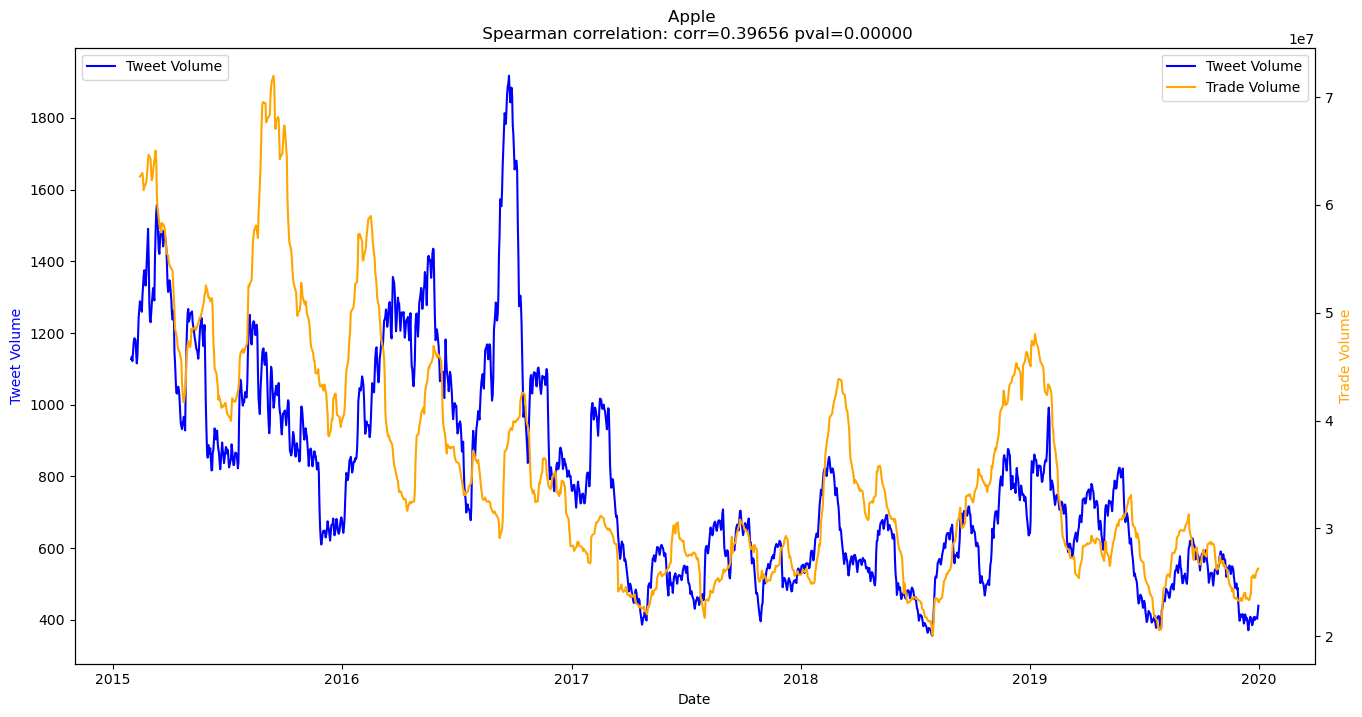

In [33]:
tweet_vol_affect(aapl,df_AAPL,"Apple")

In [34]:
tweets_vol = aapl.groupby('date1').size().rolling(30).mean().dropna()
tweets_score= aapl.groupby('date1')['score'].mean().shift(-1).rolling(30).mean().dropna()

In [35]:
tweets_score = pd.DataFrame(tweets_score)
tweets_score.index = pd.to_datetime(tweets_score.index)
tweets_score['date2']=tweets_score.index
tweets_score = tweets_score.sort_values(by='date2')
tweets_score

,score,date2
date1,,
2015-01-30,0.728686,2015-01-30
2015-01-31,0.746180,2015-01-31
2015-02-01,0.742375,2015-02-01
2015-02-02,0.733711,2015-02-02
2015-02-03,0.732151,2015-02-03
...,...,...
2019-12-26,1.076290,2019-12-26
2019-12-27,1.089775,2019-12-27
2019-12-28,1.095414,2019-12-28


In [36]:
tweets_vol = pd.DataFrame(tweets_vol, columns=['tweets_volume'] )
tweets_vol.index = pd.to_datetime(tweets_vol.index)
tweets_vol['date2']=tweets_vol.index
tweets_vol = tweets_vol.sort_values(by='date2')
tweets_vol

,tweets_volume,date2
date1,,
2015-01-30,1127.100000,2015-01-30
2015-01-31,1133.633333,2015-01-31
2015-02-01,1121.600000,2015-02-01
2015-02-02,1146.300000,2015-02-02
2015-02-03,1170.966667,2015-02-03
...,...,...
2019-12-27,405.700000,2019-12-27
2019-12-28,405.166667,2019-12-28
2019-12-29,402.633333,2019-12-29


In [57]:
df_AAPL1 = pd.merge(df_AAPL, tweets_vol, 
                    left_on='date1', right_on='date2', how='left')


In [58]:
df_AAPL1 = pd.merge(df_AAPL1, tweets_score, 
                    left_on='date1', right_on='date2', how='left')


In [59]:
columnas_a_eliminar = ['date2_x', 'date2_y']
df_AAPL1 = df_AAPL1.drop(columns=columnas_a_eliminar)
df_AAPL1

,1. open,2. high,3. low,4. close,5. volume,date1,tweets_volume,score
0,111.3900,111.4400,107.3500,109.33,53204626.0,2015-01-02,NaN,NaN
1,108.2900,108.6500,105.4100,106.25,64285491.0,2015-01-05,NaN,NaN
2,106.5400,107.4300,104.6300,106.26,65797116.0,2015-01-06,NaN,NaN
3,107.2000,108.2000,106.6950,107.75,40105934.0,2015-01-07,NaN,NaN
4,109.2300,112.1500,108.7000,111.89,59364547.0,2015-01-08,NaN,NaN
...,...,...,...,...,...,...,...,...
1253,284.6900,284.8900,282.9200,284.27,12119714.0,2019-12-24,408.033333,1.068472
1254,284.8200,289.9800,284.7000,289.91,23334004.0,2019-12-26,406.966667,1.076290
1255,291.1200,293.9700,288.1200,289.80,36592936.0,2019-12-27,405.700000,1.089775
1256,289.4600,292.6900,285.2200,291.52,36059614.0,2019-12-30,422.366667,1.075090


In [60]:
df_AAPL1 = df_AAPL1.dropna()

In [61]:
df_AAPL = df_AAPL1

In [62]:
df_AAPL

,1. open,2. high,3. low,4. close,5. volume,date1,tweets_volume,score
19,118.4000,120.0000,116.8500,117.16,83745461.0,2015-01-30,1127.100000,0.728686
20,118.0500,119.1700,116.0800,118.63,62739100.0,2015-02-02,1146.300000,0.733711
21,118.5000,119.0900,117.6100,118.65,51915749.0,2015-02-03,1170.966667,0.732151
22,118.5000,120.5100,118.3090,119.56,70149743.0,2015-02-04,1185.300000,0.731614
23,120.0200,120.2300,119.2500,119.94,42246245.0,2015-02-05,1183.500000,0.727311
...,...,...,...,...,...,...,...,...
1252,280.5300,284.2500,280.3700,284.00,24677883.0,2019-12-23,403.333333,1.045596
1253,284.6900,284.8900,282.9200,284.27,12119714.0,2019-12-24,408.033333,1.068472
1254,284.8200,289.9800,284.7000,289.91,23334004.0,2019-12-26,406.966667,1.076290
1255,291.1200,293.9700,288.1200,289.80,36592936.0,2019-12-27,405.700000,1.089775


In [63]:
df_AAPL.to_csv('df_AAPL_con_score.csv',index=False)

In [123]:
df_AAPL = pd.read_csv('df_AAPL_con_score.csv')

In [124]:
df_AAPL

,1. open,2. high,3. low,4. close,5. volume,date1,tweets_volume,score
0,118.40,120.00,116.850,117.16,83745461.0,2015-01-30,1127.100000,0.728686
1,118.05,119.17,116.080,118.63,62739100.0,2015-02-02,1146.300000,0.733711
2,118.50,119.09,117.610,118.65,51915749.0,2015-02-03,1170.966667,0.732151
3,118.50,120.51,118.309,119.56,70149743.0,2015-02-04,1185.300000,0.731614
4,120.02,120.23,119.250,119.94,42246245.0,2015-02-05,1183.500000,0.727311
...,...,...,...,...,...,...,...,...
1230,280.53,284.25,280.370,284.00,24677883.0,2019-12-23,403.333333,1.045596
1231,284.69,284.89,282.920,284.27,12119714.0,2019-12-24,408.033333,1.068472
1232,284.82,289.98,284.700,289.91,23334004.0,2019-12-26,406.966667,1.076290
1233,291.12,293.97,288.120,289.80,36592936.0,2019-12-27,405.700000,1.089775


In [130]:
df_AAPLn = df_AAPL.copy()
df_AAPLn['4. close'] = scaler.fit_transform(df_AAPL['4. close'])

In [131]:
df_AAPLn_price = np.array(df_AAPLn['4. close'])

In [133]:
df_AAPLn_date = df_AAPLn['date1'].tolist()

In [83]:
def prepare_data_sent(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset
    split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # Num_data_points should cover the entire length of the dataset for the plot.
        num_data_points = len(normalized_data_close_price)

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        train_length = data_y_train.shape[0]
        val_length = data_y_val.shape[0]

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train.reshape(-1, 1)).flatten()
        to_plot_data_y_val[split_index+config["data"]["window_size"]:split_index+config["data"]["window_size"]+val_length] = scaler.inverse_transform(data_y_val.reshape(-1, 1)).flatten()

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots
        data_date = np.arange(num_data_points)  # Assumption: data_date array is defined elsewhere or similar logic is needed.

        fig, ax = plt.subplots(figsize=(25, 5))
        ax.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
        ax.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='red')
        plt.title("Daily close prices for stock - showing training and validation data")
        plt.grid(True, linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen


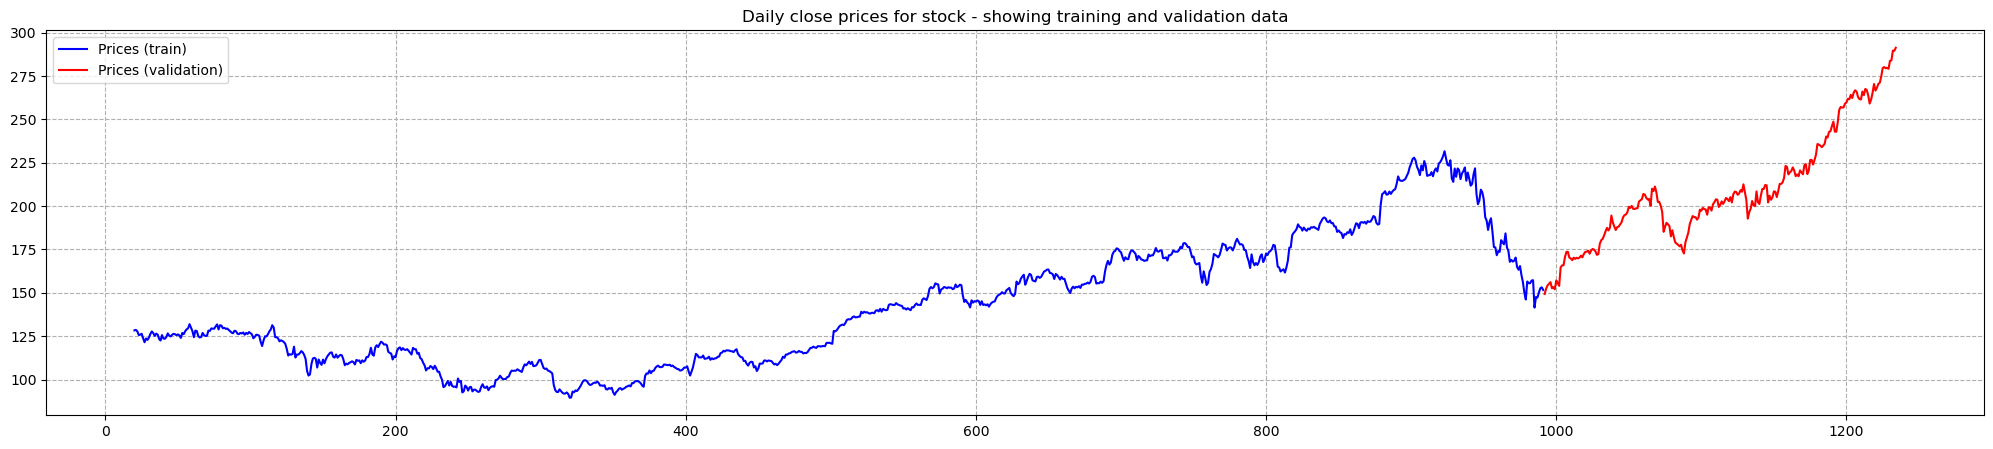

In [100]:
split_indexa, data_x_traina, data_y_traina, data_x_vala, data_y_vala, data_x_unseena = prepare_data_sent(df_AAPLna, config, plot=config["plots"]["show_plots"])

In [101]:
dataset_traina = TimeSeriesDataset(data_x_traina, data_y_traina)
dataset_vala = TimeSeriesDataset(data_x_vala, data_y_vala)

print("Train data shape", dataset_traina.x.shape, dataset_traina.y.shape)
print("Validation data shape", dataset_vala.x.shape, dataset_vala.y.shape)

Train data shape (972, 20, 1) (972,)
Validation data shape (243, 20, 1) (243,)


In [103]:
# create `DataLoader`
train_dataloadera = DataLoader(dataset_traina, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloadera = DataLoader(dataset_vala, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criteriona = nn.MSELoss()
schedulera = optim.lr_scheduler.StepLR(optimizera, step_size=config["training"]["scheduler_step_size"], gamma=0.1)
optimizera = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_traina, lr_traina = run_epoch(train_dataloadera, is_training=True)
    loss_vala, lr_vala = run_epoch(val_dataloadera)
    schedulera.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_traina, loss_vala, lr_traina))

Epoch[1/100] | loss train:0.002467, test:0.004735 | lr:0.000100
Epoch[2/100] | loss train:0.001746, test:0.004963 | lr:0.000100
Epoch[3/100] | loss train:0.001336, test:0.004587 | lr:0.000100
Epoch[4/100] | loss train:0.001744, test:0.004350 | lr:0.000100
Epoch[5/100] | loss train:0.001674, test:0.004654 | lr:0.000100
Epoch[6/100] | loss train:0.001431, test:0.004401 | lr:0.000100
Epoch[7/100] | loss train:0.001564, test:0.005241 | lr:0.000100
Epoch[8/100] | loss train:0.001557, test:0.004981 | lr:0.000100
Epoch[9/100] | loss train:0.001561, test:0.004641 | lr:0.000100
Epoch[10/100] | loss train:0.002969, test:0.004801 | lr:0.000100
Epoch[11/100] | loss train:0.002713, test:0.004590 | lr:0.000100
Epoch[12/100] | loss train:0.001801, test:0.004613 | lr:0.000100
Epoch[13/100] | loss train:0.001702, test:0.004909 | lr:0.000100
Epoch[14/100] | loss train:0.001685, test:0.004906 | lr:0.000100
Epoch[15/100] | loss train:0.001861, test:0.004889 | lr:0.000100
Epoch[16/100] | loss train:0.00151

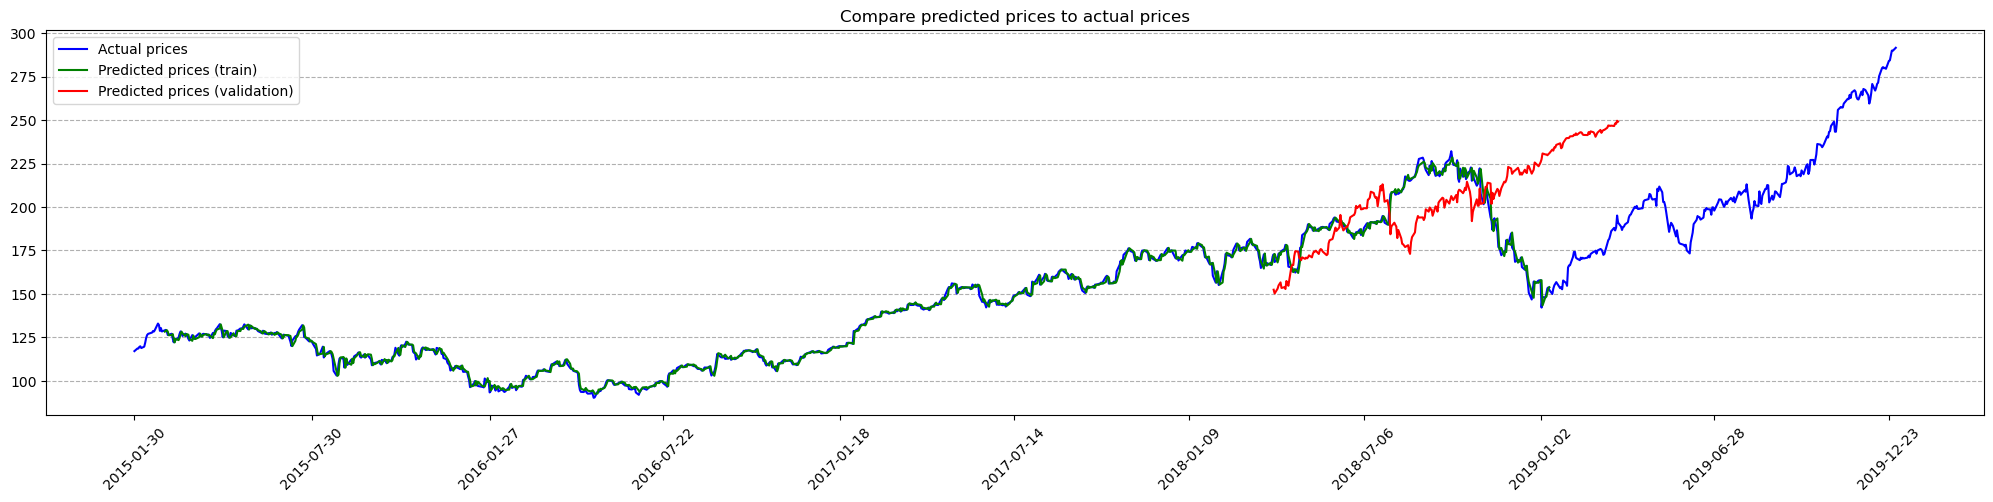

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import DataLoader
import torch.nn as nn

# Asumiendo que tienes acceso al modelo, DataLoader, configuración, etc.

# Convertir fechas de string a datetime si no están ya convertidas
if isinstance(df_AAPLn_date[0], str):
    df_AAPLn_date = [datetime.strptime(date, '%Y-%m-%d') for date in df_AAPLn_date]

# Inicialización de DataLoaders sin barajar para la predicción
train_dataloader = DataLoader(dataset_traina, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_vala, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# Predicción en datos de entrenamiento
predicted_train = np.array([])
for x, _ in train_dataloader:
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# Predicción en datos de validación
predicted_val = np.array([])
for x, _ in val_dataloader:
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# Aplicar inverse_transform a los precios reales si estaban normalizados
real_prices = scaler.inverse_transform(np.array(df_AAPLn_price).reshape(-1, 1)).flatten()

num_data_points = len(df_AAPLn_date)  # Asegúrate de que esta longitud es adecuada
window_size = config["data"]["window_size"]
split_index = int(len(dataset_traina) * config["data"]["train_split_size"])

# Ajustar los arreglos para visualización
to_plot_data_y_train_pred = np.full(num_data_points, np.nan)
to_plot_data_y_val_pred = np.full(num_data_points, np.nan)

# Asignar predicciones a los arreglos, transformando de escala si necesario
train_start = window_size
train_end = train_start + len(predicted_train)
val_start = split_index + window_size
val_end = val_start + len(predicted_val)

to_plot_data_y_train_pred[train_start:train_end] = scaler.inverse_transform(predicted_train.reshape(-1, 1)).flatten()
to_plot_data_y_val_pred[val_start:val_end] = scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()

# Visualización de los precios reales y predichos
fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(df_AAPLn_date, real_prices, label="Actual prices", color='blue')
ax.plot(df_AAPLn_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color='green')
ax.plot(df_AAPLn_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color='red')

# Configuración de título y leyenda
ax.set_title("Compare predicted prices to actual prices")
ax.legend()

# Configuración de xticks para mejorar la legibilidad
xticks_indices = np.arange(0, len(df_AAPLn_date), max(1, len(df_AAPLn_date) // 10))
ax.set_xticks([df_AAPLn_date[idx] for idx in xticks_indices])
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in np.array(df_AAPLn_date)[xticks_indices]], rotation=45)

# Configuración de la cuadrícula
ax.grid(True, which='major', axis='y', linestyle='--')

plt.show()
